In [2]:
import torch 
from torch import nn

In [3]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self):
        super().__init__()        
        self.mlp = nn.Sequential(
            nn.Linear(784, 50),
            nn.Sigmoid(),
            nn.Linear(50,15),
            nn.Sigmoid(),
            nn.Linear(15, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):        
        return self.mlp(x)


In [4]:
import numpy as np
from urllib import request
import gzip
import pickle

import random 
def shuffle_data(x, y):
    c = list(zip(x, y))
    random.shuffle(c)
    return zip(*c)

filename = [
    ["training_images","train-images-idx3-ubyte.gz"],
    ["test_images","t10k-images-idx3-ubyte.gz"],
    ["training_labels","train-labels-idx1-ubyte.gz"],
    ["test_labels","t10k-labels-idx1-ubyte.gz"]
]

def download_mnist():
    base_url = "http://yann.lecun.com/exdb/mnist/"
    for name in filename:
        print("Downloading "+name[1]+"...")
        request.urlretrieve(base_url+name[1], name[1])
    print("Download complete.")

def save_mnist():
    mnist = {}
    for name in filename[:2]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28*28)
    for name in filename[-2:]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=8)
    with open("mnist.pkl", 'wb') as f:
        pickle.dump(mnist,f)
    print("Save complete.")

def init():
    download_mnist()
    save_mnist()

def preprocess(x):
    return [y.flatten()  for y in x]


def normalize(x):
    mean_val = np.mean(x)
    stdev_val = np.std(x)
    return (x - mean_val) / stdev_val

def load(n = 5000):
    with open("mnist.pkl",'rb') as f:
        mnist = pickle.load(f)
    return (
        normalize(preprocess(mnist["training_images"][:n]  / 255.)), 
        [x[0] for x in preprocess(mnist["training_labels"][:n])], 
        normalize(preprocess(mnist["test_images"][:n]  / 255.)), 
        [x[0] for x in preprocess(mnist["test_labels"][:n])]
    )

init()

Download complete.
Save complete.


In [5]:
x_train, y_train, x_test, y_test = load()
x_train, y_train = zip(*[x for x in list(zip(x_train, y_train)) if x[1] == 5 or (random.random() < 0.12)])
x_test, y_test = zip(*[x for x in list(zip(x_test, y_test)) if x[1] == 5 or (random.random() < 0.12)])

In [6]:
# Wczytaj dane powyżej 

In [7]:
# TODO: 
print(len(x_train), len(x_test))
# ile elementów zawiera x_train, x_test 

986 1021


In [8]:
# TODO: 
# jaką długość mają wektory w x_train, x_test, zbadaj elementy o indeksie 0 
print(len(x_train[0]), len(x_test[0]))

784 784


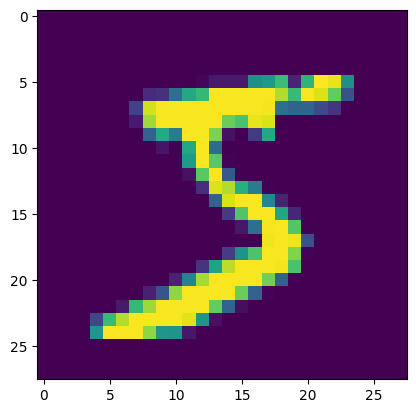

In [9]:
# TODO: 
# Zmień rozmiar przykładowego wektora na 28x28 i przypisz do zmiennej img 
img = x_train[0].reshape(28, 28)

# TODO: pokaż jak wygląda img [https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html]
from matplotlib import pyplot as plt 
plt.imshow(img)

In [10]:
# TODO: napisz funkcję która dla wejściowej listy etykiet zwraca jego binarny odpowiednik  
# dla każdego elementu w wejściowej liście sprawdź czy jest to "5" - jeśli tak przypisz jej wartość "1" w przeciwnym razie przypisz "0"

def binarize(y):
    return [int(elem == 5) for elem in y]
         

In [11]:
# TODO: zbinaryzuj y_train i y_test i zapisz do y_train_bin i y_test_bin 
y_train_bin = binarize(y_train)
y_test_bin = binarize(y_test) 

In [23]:
# training loop 

model = MultiLayerPerceptron()
bce_loss = nn.BCELoss() # TODO: https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html
losses = []
test_losses = []

batch_size = 128
adam_optimizer = torch.optim.Adam(model.parameters()) # None #TODO: https://pytorch.org/docs/stable/generated/torch.optim.Adam.html
nr_of_epochs = 120

from tqdm import tqdm 
for epoch in tqdm(range(nr_of_epochs)):
    x, y = shuffle_data(x_train,y_train_bin)
    current_index = 0 
    while current_index < len(x_train):
        batch_x = x[current_index:(current_index + batch_size)]
        batch_y = y[current_index: (current_index + batch_size)] # 
        
        tensor_batch_x = torch.Tensor(batch_x)
        tensor_batch_y = torch.Tensor(batch_y).reshape(-1, 1)
        
        pred = model.forward(tensor_batch_x)
        loss = bce_loss(pred, tensor_batch_y)

        test_loss = bce_loss(model.forward(torch.Tensor(x_test)), torch.Tensor(y_test_bin).reshape(-1,1))
            
        # Backpropagation
        loss.backward() # Liczenie gradientu wag modelu
        adam_optimizer.step() # adam oblicza nowe parametry sieci 
        adam_optimizer.zero_grad()
        
        current_index += batch_size
        losses.append(float(loss.detach().numpy()))
        test_losses.append(float(test_loss.detach().numpy()))
        
    


100%|████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:51<00:00,  2.34it/s]


<Axes: >

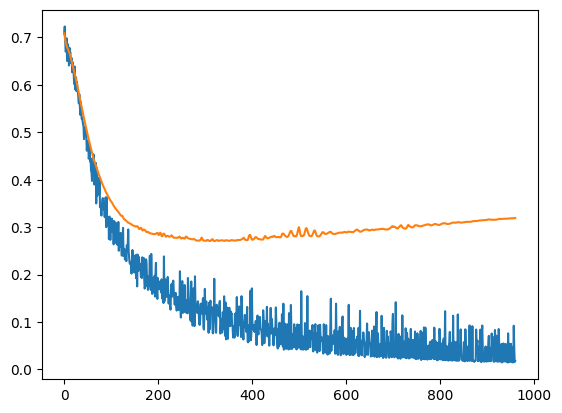

In [25]:
# TODO: Pokaż jak loss zmienia się w czasie
import pandas as pd 
pd.Series(losses).plot()
pd.Series(test_losses).plot()

In [26]:
# zjawisko jakie zaobserwowaliśmy powyżej to overfitting - model nauczył 
# się cech specyficznych dla danych treningowych i nie generalizuje dobrze 

In [32]:
# Accuracy 
# TODO: policz ile % zbioru testowego nasz model odgaduje poprawnie 

def accuracy(model, x_test, y_test, threshold):

    correct_count = 0 
    for i, x_single in enumerate(x_test):
        true_y_single = y_test[i]
        x_tensor = torch.Tensor(x_single)
        
        result = model.forward(x_tensor)
        probability_of_5 = result.detach().numpy()[0]
        if probability_of_5 > threshold and true_y_single == 1: # TODO: jeśli prawodopodobieństwo 5tki jest wyższe niż zadany threshold oraz prawdziwa etykieta to 5 
            correct_count += 1
            continue 
        if probability_of_5 <= threshold and true_y_single == 0: #TODO: # TODO: jeśli prawodopodobieństwo 5tki jest niższe niż zadany threshold oraz prawdziwa etykieta jest inna niż 5 
            correct_count += 1
            continue     
    return correct_count / (len(x_test)) # Zwróć % poprawnych odpowiedzi 


In [33]:
accuracy(model, x_test, y_test_bin, threshold=0.5)

0.9069539666993144

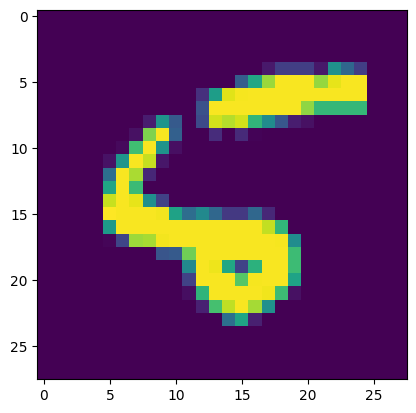

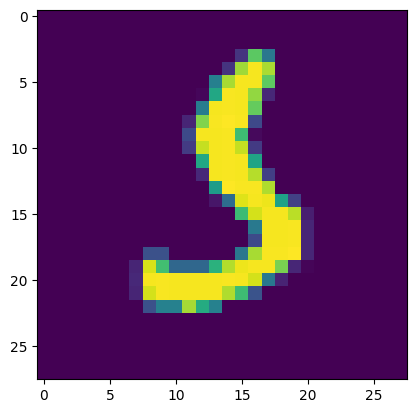

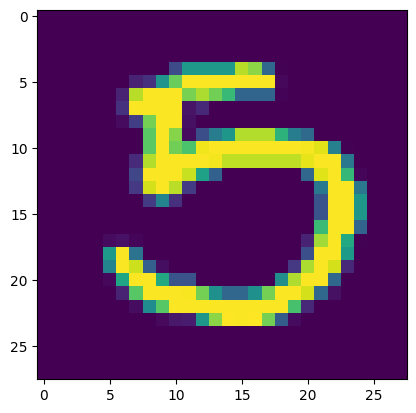

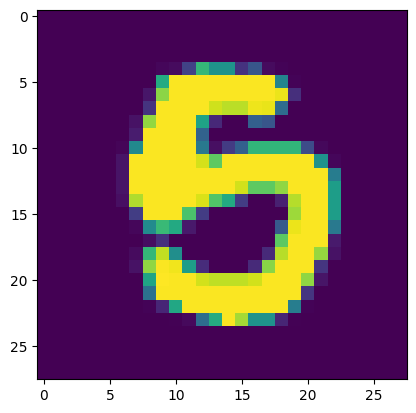

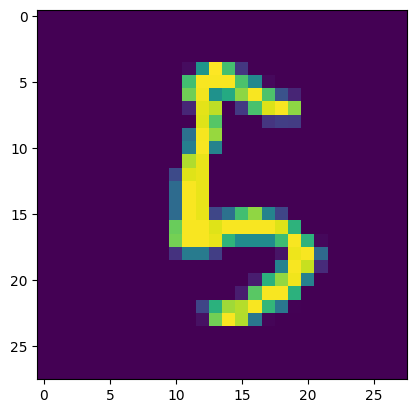

In [41]:
# wylistujmy 5 trudnych przypadków do sklasyfikowania jako "5" ze zbioru testowego 
c = 0 
for i, single_x_test in enumerate(x_test):
    if model.forward(torch.Tensor(single_x_test)).detach().numpy() < 0.1 and y_test_bin[i] == 1:
        plt.figure()
        plt.imshow(x_test[i].reshape(28,28))
        c+=1 
        if c == 5:
            break
        